# Assignment - Unsupervised Learning
This assignment is for Big Data in Finance II.

## 0 Setup
Download the lending club data saved on the hub as 
*/Data/lendingclub_cleaned/Loan_data.csv*.

Keep the following list of borrower characteristics:

`[loan_amnt, int_rate, annual_inc, avg_cur_bal, emp_length, fico_range_high, delinq_amnt, revol_util]`

Also keep `loan_status` and convert it into a default indicator (which is one if the loan status is "Fail")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input

np.seterr(all='ignore')
np.random.seed(123)

In [4]:
# load data
df = pd.read_csv('../data/lendingclub_cleaned/Loan_data.csv', low_memory = False, index_col=0)

# keep list of borrower characteristers
clist = ['loan_status', 'loan_amnt', 'int_rate', 'annual_inc', 'avg_cur_bal', 'emp_length', 'fico_range_high', 'delinq_amnt', 'revol_util']
df = df[clist]

# turn loan_status into a default indicator
df['loan_status'] = (df['loan_status'] == 'Fail')

# inspect data information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107260 entries, 126413292 to 118607680
Data columns (total 9 columns):
loan_status        107260 non-null bool
loan_amnt          107260 non-null float64
int_rate           107260 non-null float64
annual_inc         107260 non-null float64
avg_cur_bal        107260 non-null float64
emp_length         107260 non-null int64
fico_range_high    107260 non-null float64
delinq_amnt        107260 non-null float64
revol_util         107260 non-null float64
dtypes: bool(1), float64(7), int64(1)
memory usage: 7.5 MB


## 1 Pricipal Components
Compute the first 2 principal components.

Make a biplot and interpret the main sources of variation in the data.

## 2 Visualize Variation
Make a table with the percentage of variance explained by q
principal components. (q = 1 to 8)

Choose suitable number of principal components used in classification.

## 3 Prediction
Reallocate the dataset into 80% traning set, 10% validation set, 10% test set.
Create a synthetic dataset by undersampling non-defaulters(<70%).

Run 8 logistic classifiers that predict default as a function of the first q principal components.

## 4 Tune Parameter
Get implied probabilities of default of all borrowers in validation set.

Use these predictions and actual outcomes to calculate the cross-entropy loss for each q.

Choose q which has the lowest loss on validation set. Evaluate performance of model on test set.

## 5 Alternatives to PCA
Pseudocode for backprop and gradient descent, for a nonlinear q-dimensional representation of consumer characteristics that uses <u>autoencoder</u>. [Goodfellow et al., Ch.14](https://www.deeplearningbook.org/contents/autoencoders.html)

Train this model, get insights relative to PCA.

In [5]:
# set up data for classification
# class label: default
y = df['loan_status'].values.reshape(1,-1)
print(y.shape)

# features: the remaining columns
X = df.drop(columns = 'loan_status').values.T

# standardise inputs
X = (X - np.mean(X,axis=1).reshape(-1,1)) / np.std(X,axis=1).reshape(-1,1)
print(X.shape)

(1, 107260)
(8, 107260)


In [15]:
# in order to plot in a 2D figure
encoding_dim = 2

# this is our input placeholder
input_img = Input(shape=(107260,))

# encoder layers
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)

# decoder layers
decoded = Dense(10, activation='relu')(encoder_output)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(107260, activation='tanh')(decoded)

# construct the autoencoder model
autoencoder = Model(input=input_img, output=decoded)

# construct the encoder model for plotting
encoder = Model(input=input_img, output=encoder_output)

# compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')


C:\Users\timzh\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
C:\Users\timzh\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [19]:
# training
autoencoder.fit(X, X,
                nb_epoch=20,
                batch_size=256,
                shuffle=True)

C:\Users\timzh\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/20
8/8 [==============================] - 0s 62ms/step - loss: 0.6294
Epoch 2/20
8/8 [==============================] - 1s 70ms/step - loss: 0.6263
Epoch 3/20
8/8 [==============================] - 1s 81ms/step - loss: 0.6233
Epoch 4/20
8/8 [==============================] - 1s 76ms/step - loss: 0.6280
Epoch 5/20
8/8 [==============================] - 1s 67ms/step - loss: 0.6187
Epoch 6/20
8/8 [==============================] - 1s 73ms/step - loss: 0.6185
Epoch 7/20
8/8 [==============================] - 1s 65ms/step - loss: 0.6156
Epoch 8/20
8/8 [==============================] - 1s 69ms/step - loss: 0.6129
Epoch 9/20
8/8 [==============================] - 1s 67ms/step - loss: 0.6084
Epoch 10/20
8/8 [==============================] - 1s 72ms/step - loss: 0.6043
Epoch 11/20
8/8 [==============================] - 1s 68ms/step - loss: 0.6001
Epoch 12/20
8/8 [==============================] - 1s 71ms/step - loss: 0.5977
Epoch 13/20
8/8 [==============================] - 1s 68ms/st

'\nEpoch 20/20\n60000/60000 [==============================] - 7s - loss: 0.0398\n'

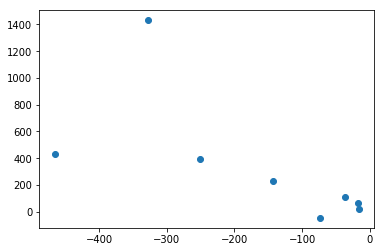

In [44]:
# plotting
encoded_imgs = encoder.predict(X)
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1]) # something wrong here
plt.show()

## 6 K-Means Clustering
Cluster borrowers into K groups using K-means.

## 7 Tune Paramerter
Design a graphical tool that helps pick good number of K.

Interpret characteristics
of borrowers in each cluster.